# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : Reproducibility
## Chapter : Flow and geodesics

We compute the geodesic flow, minimal geodesics, and investigate forward and reverse AD, on the CPU and GPU, checking for consistency.

## 0. Importing the required libraries

In [5]:
import sys; sys.path.insert(0,"../..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Isotropic_Repro','GPU'))

In [6]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [7]:
from agd import HFMUtils
from agd import AutomaticDifferentiation as ad
from agd import Metrics
import agd.AutomaticDifferentiation.cupy_generic as cugen
norm_infinity = ad.Optimization.norm_infinity
from agd.HFMUtils import RunGPU,RunSmart

In [8]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,RunGPU
    HFMUtils,ad,cugen,RunGPU = rreload([HFMUtils,ad,cugen,RunGPU],"../..")    

In [9]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
RunSmart = cugen.cupy_get_args(RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

In [10]:
def RunCompare(gpuIn,check=True):
    gpuOut = RunGPU(gpuIn)
    if gpuIn.get('verbosity',1): print("---")
    cpuOut = RunSmart(gpuIn)
    print("Max |gpuValues-cpuValues| : ", norm_infinity(gpuOut['values'].get()-cpuOut['values']))
    cpuTime = cpuOut['FMCPUTime']; gpuTime = gpuOut['solverGPUTime'];
    print(f"Solver time (s). GPU : {gpuTime}, CPU : {cpuTime}. Device acceleration : {cpuTime/gpuTime}")
    assert not check or cp.allclose(gpuOut['values'],cpuOut['values'],atol=1e-6)
    return gpuOut,cpuOut

# 1. Isotropic metrics

In [109]:
ReloadPackages()

In [110]:
n=200
hfmIn = HFMUtils.dictIn({
    'model':'Isotropic2',
    'seeds':[[0.,0.]],
    'exportValues':1,
    'cost':cp.array(1.),
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)

Casting output of function array from float64 to float32


In [111]:
gpuOut = RunGPU(hfmIn)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the values array (setting seeds,...)
Preparing the GPU kernel
#define Scalar_macro
typedef float Scalar;
#define Int_macro
typedef int Int;
#define multiprecision_macro 0
#define pruning_macro 0
#define shape_i_macro
const int shape_i[2] = {24,24};
#define niter_i_macro
const int niter_i=1;
#define ndim_macro 2
#define minChg_freeze_macro 0
#define flow_vector_macro 0
const int size_i = 576;
const int log2_size_i = 10;
#include "Isotropic_.h"
// Date cuda code last modified : 1586042035.2455897

Setup and run the eikonal solver
GPU solve took 0.006499052047729492 seconds, in 10 iterations.
Post-Processing


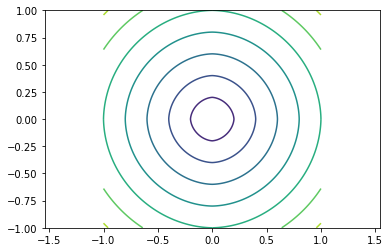

In [114]:
plt.axis('equal')
plt.contour(*hfmIn.Grid(),gpuOut['values'])